# 프로젝트 : 단어 Level로 번역기 업그레이드하기

==================================================================================================

- 학습과 테스트 시의 원활한 진행을 위해서 데이터에서 상위 33,000개의 샘플만 사용해주세요.

- 33000개 중 3000개는 테스트 데이터로 분리하여 모델을 학습한 후에 번역을 테스트 하는 용도로 사용합니다.

---
## 목차

> ### 1. 데이터 불러오기
>
> ### 2. 데이터 전처리
> 
> ### 3. 모델 구성하기
> 
> ### 4. 모델 학습
> 
> ### 5. 모델 평가하기
> 
> ### 6. 회고
> 
> ### 7. Reference
> 
> ### 8. 자기다짐 및 아쉬운 점

---
## 루브릭 달성 조건

> 1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 잘 이루어졌다.
>     - 구두점, 대소문자, 띄어쓰기 등 번역기 모델에 요구되는 전처리가 정상적으로 진행되었다.
> 2. seq2seq 기반의 번역기 모델이 정상적으로 구동된다.
>    - seq2seq 모델 훈련결과를 그래프로 출력해보고, validation loss그래프가 우하향하는 경향성을 보이며 학습이 진행됨이 확인되었다.
> 3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.
>    - 테스트용 디코더 모델이 정상적으로 만들어졌으며, input(영어)와 output(프랑스어) 모두 한글로 번역해서 결과를 출력해보았고, 둘의 내용이 유사함을 확인하였다.

---
## 1. 데이터 불러오기

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import re

tf.random.set_seed(42)

- 필요한 라이브러리들을 import해주고 random seed를 42로 고정해주었습니다.

In [3]:
file_path = './data/fra.txt'
# file_path = '/content/drive/MyDrive/exploration/10_translation/data/fra.txt'
df = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')

In [4]:
df.head()

,eng,fra,cc
0,Go.,Va !,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
1,Go.,Marche.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
2,Go.,En route !,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
3,Go.,Bouge !,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
4,Hi.,Salut !,CC-BY 2.0 (France) Attribution: tatoeba.org #5...


- eng to fra 번역 데이터를 가져왔습니다. Go. - Va! 와 같이 쌍으로 이루어져 있는 데이터입니다.
- 하지만 저희에겐 필요없는 cc 컬럼도 있는것을 확인할 수 있습니다.

In [5]:
df.isna().sum()

eng    0
fra    0
cc     0
dtype: int64

- 결측치가 없는것도 확인했으니 데이터에 문제는 없는거로 판단됩니다.
- 필요없는 cc컬럼을 삭제해주도록 하겠습니다.

In [6]:
del df['cc']

In [7]:
df.head()

,eng,fra
0,Go.,Va !
1,Go.,Marche.
2,Go.,En route !
3,Go.,Bouge !
4,Hi.,Salut !


- 잘 삭제가 되었습니다. 이제 전처리를 해도 괜찮을듯 합니다.

---
## 2. 데이터 전처리

#### 요구사항

1. 구두점(Punctuation)을 단어와 분리해주세요.
2. 소문자로 바꿔주세요.
3. 띄어쓰기 단위로 토큰를 수행하세요.
4. 디코더 문장에 시작과 종료 토큰을 넣어주세요.

- 토큰화 전 : 'He is a Good boy!'

- 토큰화 후 : [start, 'he', 'is', 'a', 'good', 'boy', '!', end]

In [8]:
df = df.sample(33000, random_state=42)

- 일단 데이터를 상위 33000개를 사용하라고 했습니다만.. 확인 결과 후반부 데이터로 갈수록 문장의 길이가 길어지는것을 확인할 수 있었습니다.
  
  
- 왠지 짧은 문장 데이터 33000개는 너무 쉬울거같더군요. 랜덤하게 33000개를 뽑아서 사용하겠습니다.

In [9]:
df.head()

,eng,fra
3982,Tom is huge.,Tom est immense.
193522,Why did you ask Tom to do that when you knew h...,"Pourquoi as-tu demandé à Tom de faire cela, al..."
187455,This bread is really delicious. Where did you ...,Ce pain est vraiment délicieux. Où l'as-tu ach...
100881,Distilled water has no taste.,L'eau distillée n'a pas de goût.
75160,Tom asked us to sit down.,Tom nous a demandé de nous asseoir.


- index를 보니 무작위 선정이 잘 된것을 확인할 수 있습니다. 
- 정리해주도록 하겠습니다.

In [10]:
df = df.reset_index()

In [11]:
df.head()

,index,eng,fra
0,3982,Tom is huge.,Tom est immense.
1,193522,Why did you ask Tom to do that when you knew h...,"Pourquoi as-tu demandé à Tom de faire cela, al..."
2,187455,This bread is really delicious. Where did you ...,Ce pain est vraiment délicieux. Où l'as-tu ach...
3,100881,Distilled water has no taste.,L'eau distillée n'a pas de goût.
4,75160,Tom asked us to sit down.,Tom nous a demandé de nous asseoir.


- 깔끔하게 정리되었군요 원래 index였던 컬럼은 삭제해주도록 하겠습니다.

In [12]:
del df['index']

In [13]:
df.head()

,eng,fra
0,Tom is huge.,Tom est immense.
1,Why did you ask Tom to do that when you knew h...,"Pourquoi as-tu demandé à Tom de faire cela, al..."
2,This bread is really delicious. Where did you ...,Ce pain est vraiment délicieux. Où l'as-tu ach...
3,Distilled water has no taste.,L'eau distillée n'a pas de goût.
4,Tom asked us to sit down.,Tom nous a demandé de nous asseoir.


- 아주 만족스럽습니다. 깔끔하게 정리되었습니다.

In [14]:
start_token = '<start>'
end_token = '<end>'

- start 토큰과 end 토큰을 만들어 target 데이터에 적용시키도록 하겠습니다.
- target 데이터는 2번의 디코딩 과정을 거쳐야 하기 때문에 start 토큰과 end 토큰이 필요합니다.

In [15]:
df.fra = df.fra.apply(lambda x : start_token +' '+ x + end_token)

- lambda 식을 이용해 앞 뒤로 토큰들을 붙여주었습니다.

In [16]:
df.head()

,eng,fra
0,Tom is huge.,<start> Tom est immense.<end>
1,Why did you ask Tom to do that when you knew h...,<start> Pourquoi as-tu demandé à Tom de faire ...
2,This bread is really delicious. Where did you ...,<start> Ce pain est vraiment délicieux. Où l'a...
3,Distilled water has no taste.,<start> L'eau distillée n'a pas de goût.<end>
4,Tom asked us to sit down.,<start> Tom nous a demandé de nous asseoir.<end>


- 적용이 잘 되었군요

In [17]:
eng_list = []

for sentence in df['eng']:
    sentence = sentence.lower()
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = sentence.split()
    eng_list.append(sentence)

In [18]:
fra_list = []

for sentence in df['fra']:
    sentence = sentence.lower()
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = sentence.split()
    fra_list.append(sentence)

- 전처리 과정을 for문으로 적용하였습니다.
- .lower()를 이용해 모든 문자를 소문자로 바꿔주고
- re.sub(r"([?.!,¿])", r" \1 ", sentence) 를 이용해 ?.!,¿ 라는 특수문자 양 옆으로 공백을 1개씩 추가해 주었습니다.
- .split() 을 통해 공백을 기준으로 나누어 주었습니다.

In [19]:
eng_max_len = len(eng_list[0])

for i in range(len(eng_list)):
    if i == 0:
        continue
    elif len(eng_list[i]) > eng_max_len:
        eng_max_len = len(eng_list[i])
    else:
        continue
        
print('영단어 최대 문장 길이는:', eng_max_len, '입니다.')

영단어 최대 문장 길이는: 51 입니다.


In [20]:
fra_max_len = len(fra_list[0])

for i in range(len(fra_list)):
    if i == 0:
        continue
    elif len(fra_list[i]) > fra_max_len:
        fra_max_len = len(fra_list[i])-2
    else:
        continue
        
print('프랑스어 최대 문장 길이는:', fra_max_len, '입니다.')

프랑스어 최대 문장 길이는: 59 입니다.


- 각각 샘플중 영어의 최대 문장길이는 51, 프랑스어의 최대 문장길이는 59인것을 알수있습니다. 이를 통해 토큰화 과정을 진행해 보겠습니다.

In [21]:
def tokenize(eng, fra):
    tokenizer_eng = tf.keras.preprocessing.text.Tokenizer(num_words=15000,
                                                      filters = " ",
                                                      char_level=True)
    
    tokenizer_fra = tf.keras.preprocessing.text.Tokenizer(num_words=15000,
                                                      filters = " ",
                                                      char_level=True)
    
    tokenizer_eng.fit_on_texts(eng)
    tokenizer_fra.fit_on_texts(fra)

    eng = tokenizer_eng.texts_to_sequences(eng)
    fra = tokenizer_fra.texts_to_sequences(fra)
    
    return eng, fra, tokenizer_eng, tokenizer_fra

- Tokenizer 함수를 이용해 단어장의 크기는 15000개, 필터는 없음으로 설정하고 char_level=True 를 이용하여 모든 단어를 토큰화하도록 하였습니다.
   - 여기서 알게된 내용이지만 위에서 전처리한 과정을.. 굳이 할 필요가 없던것을 깨달았습니다. Tokenizer 의 파라미터에 lower, split이 포함된것을 확인할 수 있었습니다.
   
   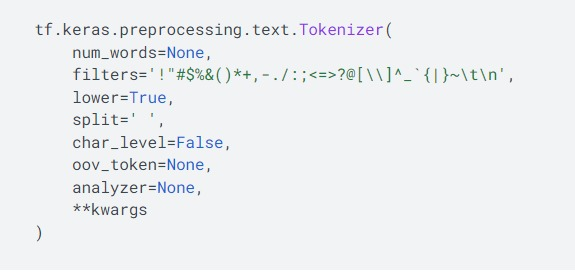

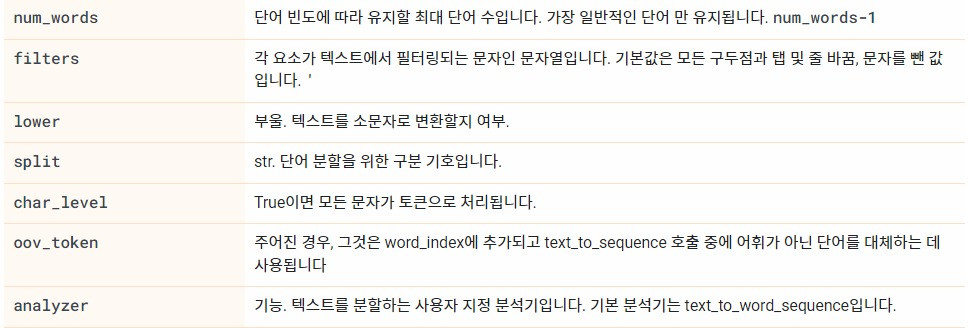

- 그 후 fit_on_text를 통해 텍스트를 Tokenizer에 fit 시키고 text_to_sequence를 이용해 정수형태로 변환해 주었습니다.

In [22]:
eng, fra, tokenizer_eng, tokenizer_fra = tokenize(eng_list, fra_list)

In [23]:
eng_input = eng
fra_input = [[ word for word in text if word != tokenizer_fra.word_index[end_token] ] for text in fra] 
fra_output = [[ word for word in text if word != tokenizer_fra.word_index[start_token] ] for text in fra] 

- tokenize 함수를 이용해 eng_input, fra_input, fra_output 3개의 변수로 나누어 주었습니다.

- 특히 fra는 input은 end_token 없이 start_token만 가지게 되고 output은 반대로 end_token만 가지게 처리해주었습니다.

In [25]:
eng_input = tf.keras.preprocessing.sequence.pad_sequences(eng_input, padding='post', maxlen=eng_max_len)
fra_input = tf.keras.preprocessing.sequence.pad_sequences(fra_input, padding='post', maxlen=fra_max_len)
fra_output = tf.keras.preprocessing.sequence.pad_sequences(fra_output, padding='post', maxlen=fra_max_len)

- 패딩작업을 통해 패딩의 위치는 post, 길이는 아까 지정해놓았던 max_len으로 설정하였습니다. 
  
  
  
- 여기서 공부하며 느끼게 된것이지만 padding은 pre가 좋다고 배웠습니다만 별 상관이 없다는것을 알게되었습니다.
  
  
- LSTM layer의 특성상 뒤로 갈수록 희미해지는 특성을 완전히 보완하지 못했기에 padding을 pre로 설정하고 뒤쪽의 단어를 인식하는것이 좋다고 배웠으나 masking을 이용하면 post여도 padding을 무시할수 있게 만들 수 있다는 것을 알게되었습니다.

  
  
#### RNN의 특성

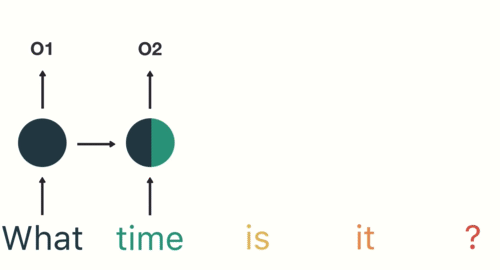

- 뒤로 갈 수록 점점 희미해지는 memory 가 있다.

In [26]:
eng_input.max()

8406

In [27]:
fra_input.max()

14474

In [28]:
fra_output.max()

14474

- 각각 영어 단어장은 8406개
- 프랑스어 단어장은 14474개로 잘 토큰화가 된것을 확인할 수 있습니다.

In [30]:
for idx in tokenizer_eng.index_word:
    print(idx, ":", tokenizer_eng.index_word[idx])
    
    if idx == 10: break    
        
eng_index_word = tokenizer_eng.index_word        

1 : .
2 : i
3 : you
4 : to
5 : the
6 : ?
7 : a
8 : tom
9 : is
10 : that


In [31]:
for idx in tokenizer_fra.index_word:
    print(idx, ":", tokenizer_fra.index_word[idx])
    
    if idx == 10: break    
        
fra_index_word = tokenizer_fra.index_word        

1 : <start>
2 : <end>
3 : .
4 : je
5 : de
6 : ?
7 : pas
8 : que
9 : à
10 : ne


In [29]:
fra_input[:2]

array([[   1,   14,   16, 5125,    3,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [   1,   56,  103,  274,    9,   14,    5,   30,   57,   17,  408,
           8,   19,  258,   50,   10,  612,    7,    6,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0]], dtype=int32)

- input data라서 1 즉 start_token으로 시작하는것을 알 수 있습니다.
- 토큰화가 잘 되었군요

---
## 3. 모델 구성하기

In [32]:
eng_vocab_size = eng_input.max()+1
fra_vocab_size = fra_input.max()+1
eng_vector_dim = eng_max_len
fra_vector_dim = fra_max_len
hidden_state = 256

print('영어 단어장의 크기: ', eng_vocab_size)
print('프랑스어 단어장의 크기: ', fra_vocab_size)
print('---'*20)
print('영어 단어 차원의 크기: ', eng_vector_dim)
print('프랑스어 단어 차원의 크기: ', fra_vector_dim)
print('---'*20)
print('영어 최대단어 길이: ', eng_max_len)
print('프랑스어 최대단어 길이: ', fra_max_len)
print('---'*20)
print(eng_input.shape)
print('---'*20)
print(fra_input.shape)
print('---'*20)
print(fra_output.shape)
print('---'*20)

영어 단어장의 크기:  8407
프랑스어 단어장의 크기:  14475
------------------------------------------------------------
영어 단어 차원의 크기:  51
프랑스어 단어 차원의 크기:  59
------------------------------------------------------------
영어 최대단어 길이:  51
프랑스어 최대단어 길이:  59
------------------------------------------------------------
(33000, 51)
------------------------------------------------------------
(33000, 59)
------------------------------------------------------------
(33000, 59)
------------------------------------------------------------


- 각각 단어장의 크기 +1을 vocab_size로 지정하고 vector_dim은 max_len으로 그리고 hidden_state는 256으로 지정해주었습니다.
  
  
- 각각 33000, vector_dim 의 형태로 잘 구성되어 있는것을 확인할 수 있군요.

In [33]:
eng_input_train, fra_input_train, fra_output_train = eng_input[:30000], fra_input[:30000], fra_output[:30000]
eng_input_test, fra_input_test, fra_output_test = eng_input[30000:], fra_input[30000:], fra_output[30000:]

print('영어 훈련셋 크기: ', eng_input_train.shape)
print('프랑스어 1번 훈련셋 크기: ', fra_input_train.shape)
print('프랑스어 2번 훈련셋 크기: ', fra_output_train.shape)
print('영어 벨리데이션셋 크기: ', eng_input_test.shape)
print('프랑스어 1번 벨리데이션셋 크기: ', fra_input_test.shape)
print('프랑스어 2번 벨리데이션셋 크기: ', fra_output_test.shape)

영어 훈련셋 크기:  (30000, 51)
프랑스어 1번 훈련셋 크기:  (30000, 59)
프랑스어 2번 훈련셋 크기:  (30000, 59)
영어 벨리데이션셋 크기:  (3000, 51)
프랑스어 1번 벨리데이션셋 크기:  (3000, 59)
프랑스어 2번 벨리데이션셋 크기:  (3000, 59)


- train set 30000개, validation set 3000개로 구성하였습니다.
- 잘 나누어 진것을 확인할 수 있습니다.

In [34]:
encoder_inputs = tf.keras.layers.Input(shape=(None,))
enc_emb = tf.keras.layers.Embedding(eng_vocab_size, hidden_state, mask_zero=True)(encoder_inputs)
encoder_lstm = tf.keras.layers.LSTM((hidden_state), return_state=True, dropout=0.2, activation='gelu')
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

In [35]:
decoder_inputs = tf.keras.layers.Input(shape=(None,))
dnc_emb = tf.keras.layers.Embedding(fra_vocab_size, hidden_state, mask_zero=True)(decoder_inputs)
decoder_lstm = tf.keras.layers.LSTM((hidden_state), return_state=True, return_sequences=True, dropout=0.2, activation='gelu')
decoder_outputs, _, _ = decoder_lstm(dnc_emb, initial_state=encoder_states)

- functional 방법을 통해 신경망을 쌓았습니다.
  
  
- Embedding layer를 우선 쌓고 특히 여기서 mask_zero 파라미터를 적용하여 post에 위치한 padding 들은 의미가 없다는 정보를 주었습니다.
- 이로 인해 패딩의 위치가 pre던 post던 상관 없는것을 알 수 있게 되었습니다.

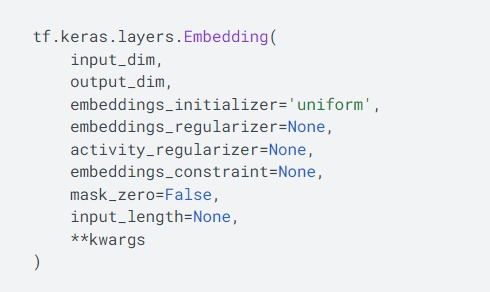

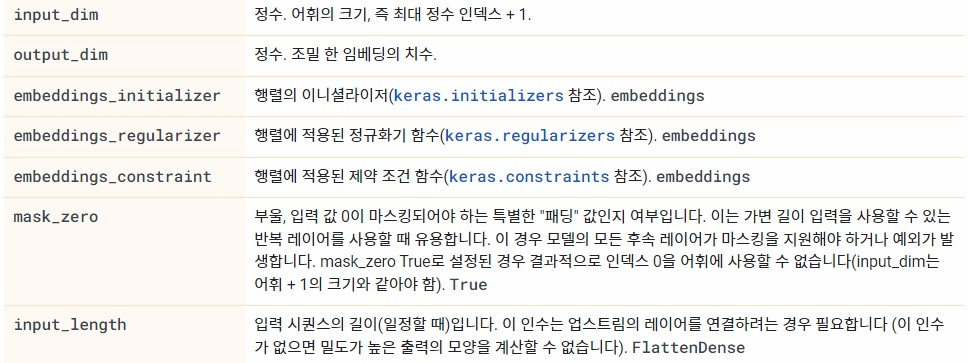

- 또한 LSTM에선 hidden_state와 cell_state를 사용해야하기 때문에 return_state=True로 설정하였고 overfitting 방지를 위해 dropout = 0.2를 설정해주었습니다. 
  
  
- 특히, 여기서 공부하게된 내용으로 activation function 중 gelu라는것이 있다는 것을 알게되었습니다.
- 기본적으로 LSTM은 'tanh' 를 activation 함수로 이용하게 되는데 이는 -1, 1값 사이의 값을 이용해 activaiton 하게되는 함수이지만 생각해보니 저의 데이터는 음수의 값을 가지는 데이터가 없다는 생각을 하게 되었고 왜 tanh를 사용해야할까? 라는 생각을 하게되었습니다.
  
  
- 그래서 0, max 값을 이용하는 relu를 이용해보았으나 dead relu 현상이 발생하여 값이 죽어버리는 경우가 생기게 되었고 Leakyrelu를 이용해 보았으나 여기선 또 이상하게도 Loss값이 2억에 근접하는 모습을 보여주는 현상을 확인하였습니다. 아마 Gradient explode 때문이지 않을까 생각합니다.
  
  
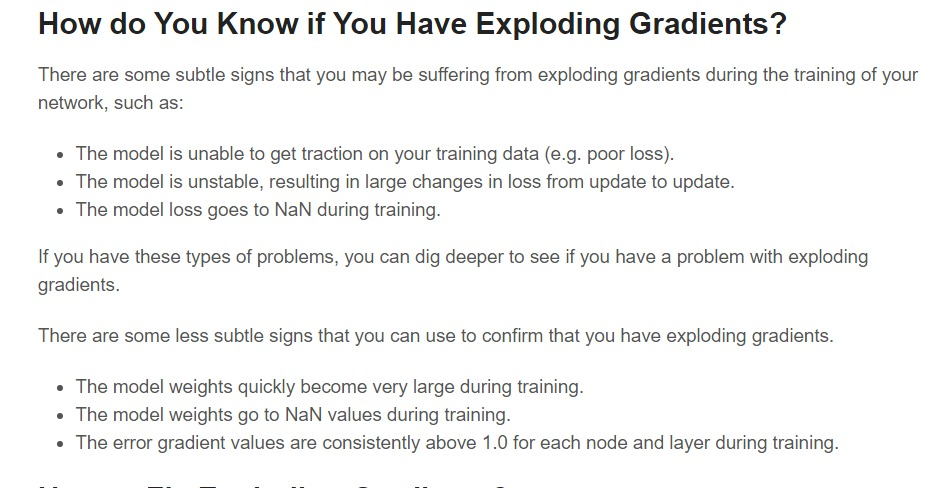

- 해당 사진에서 말하는 poor loss 때문이지 않았나 싶습니다.

- 그렇게 하여 채용하게된 activation fuction으로 gelu를 채택하게 되었습니다.

  
  
#### gelu 란?

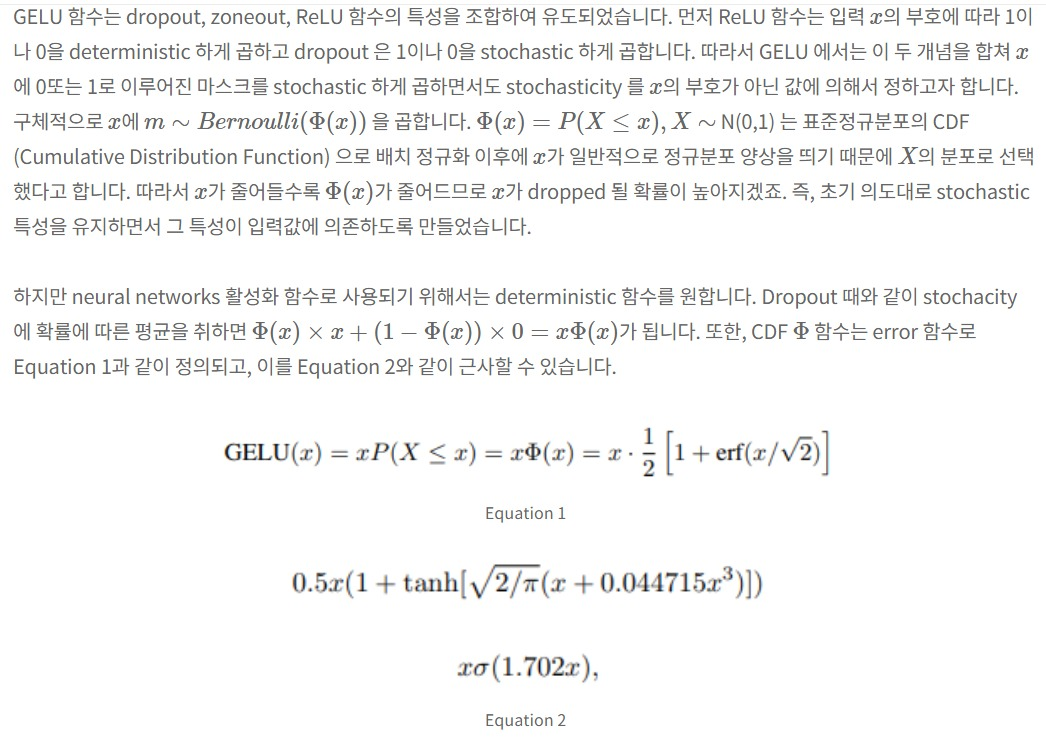

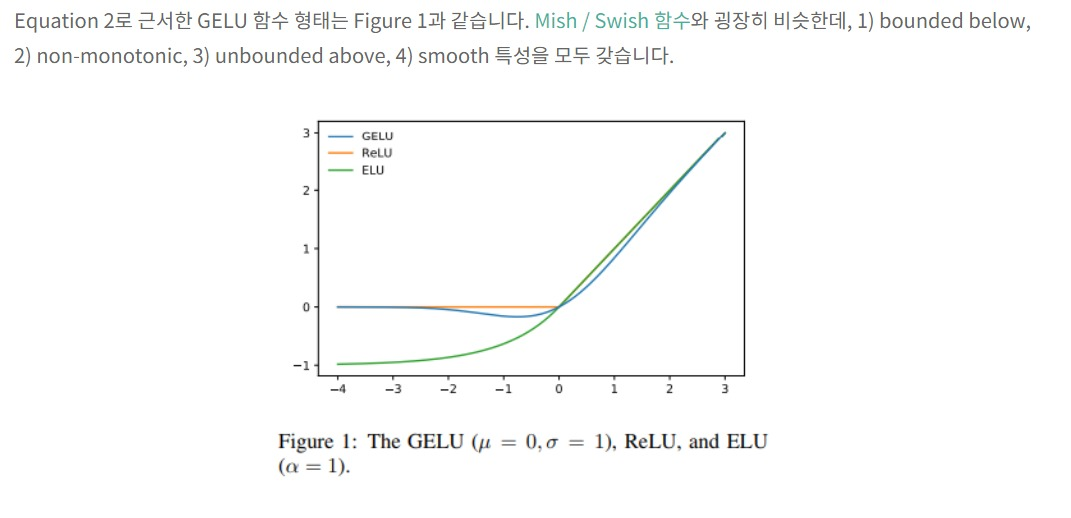

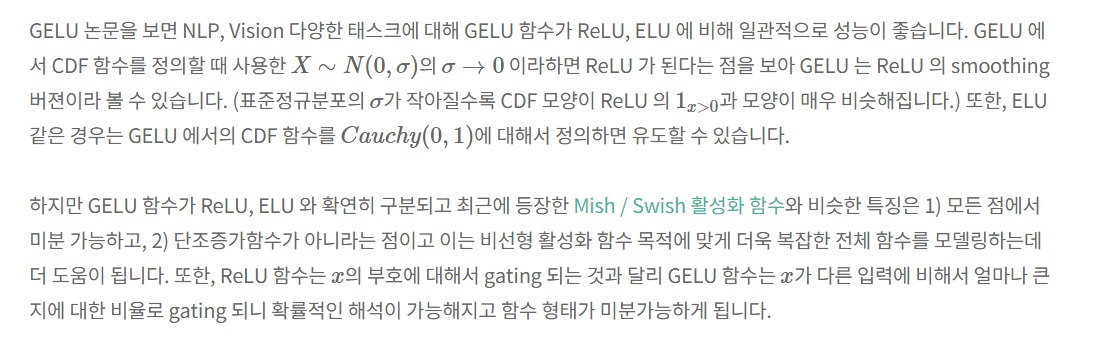

In [36]:
decoder_softmax_layer = tf.keras.layers.Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

- 마지막 출력층으로 softmax 를 이용한 layer를 만들었습니다.
- 이는 vocab_size로 softmax 분류 모델과 같습니다.

In [37]:
model = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 256)    2152192     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 256)    3705600     input_2[0][0]                    
______________________________________________________________________________________________

- optimizer로는 adam을 사용하였고 loss로 sparse_categorical_crossentropy를 사용하였습니다.

- 여기서도 알게된 내용이지만 categorical_crossentropy와 sparse_categorical_crossentropy의 차이로는 각각 원핫벡터의 형태일때와 정수의 형태일때 각각 사용한다고 배웠습니다.

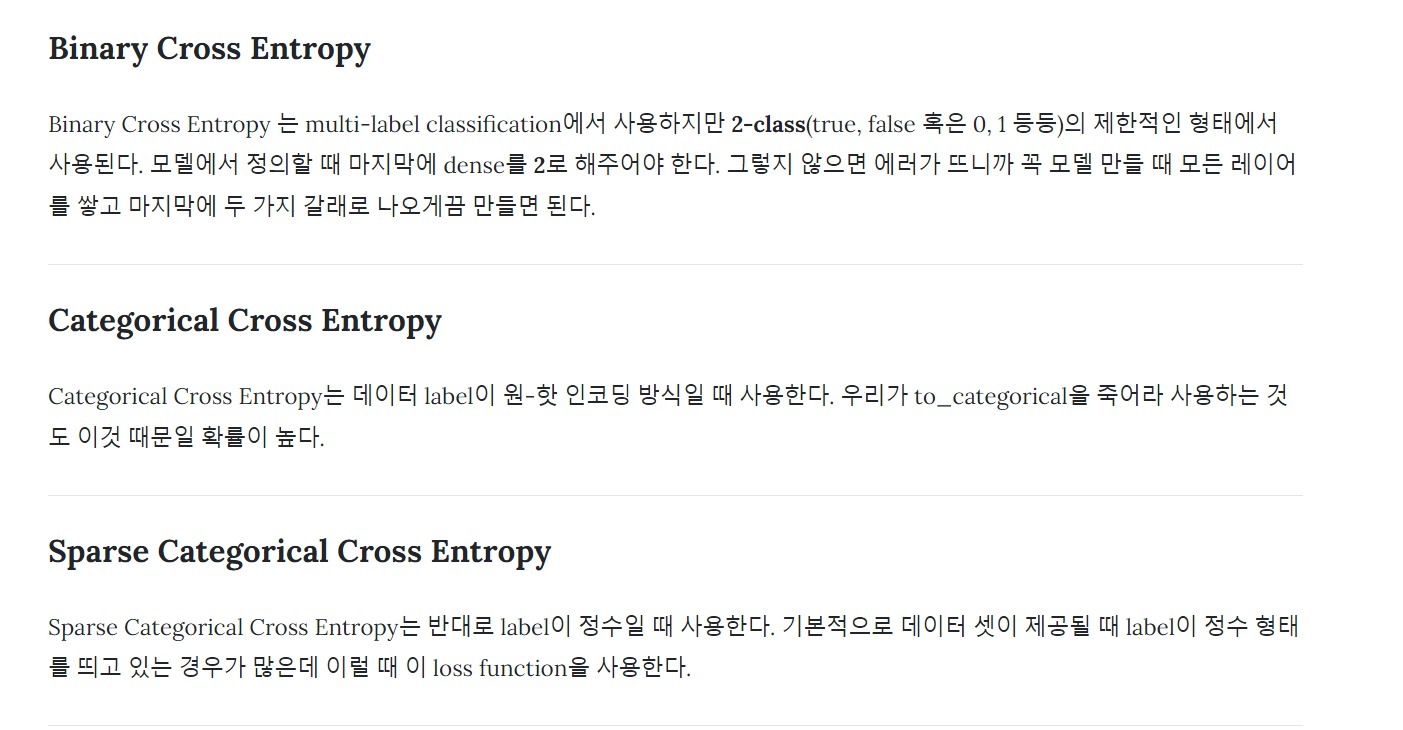

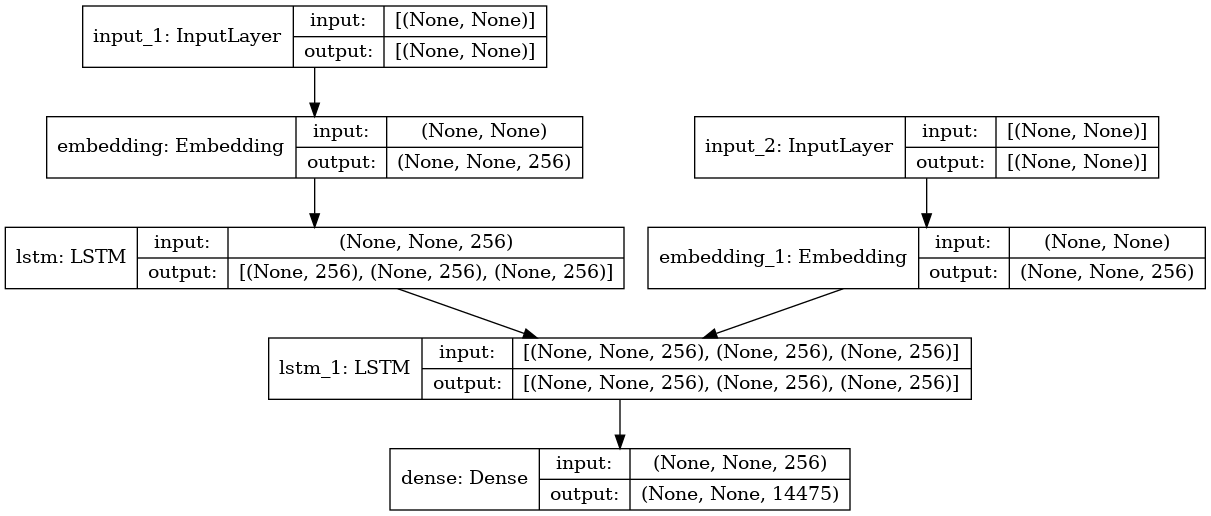

In [38]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True)

- 간단하게 나의 모델을 도식화해주는 plot_model을 이용하여 도식화하였습니다. 잘 생성된 것을 볼 수 있군요.

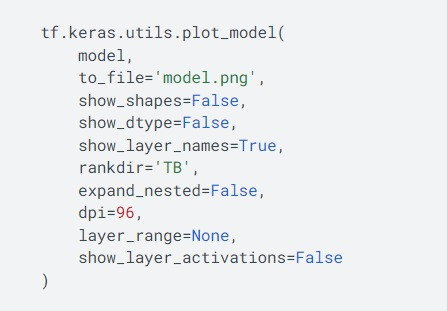

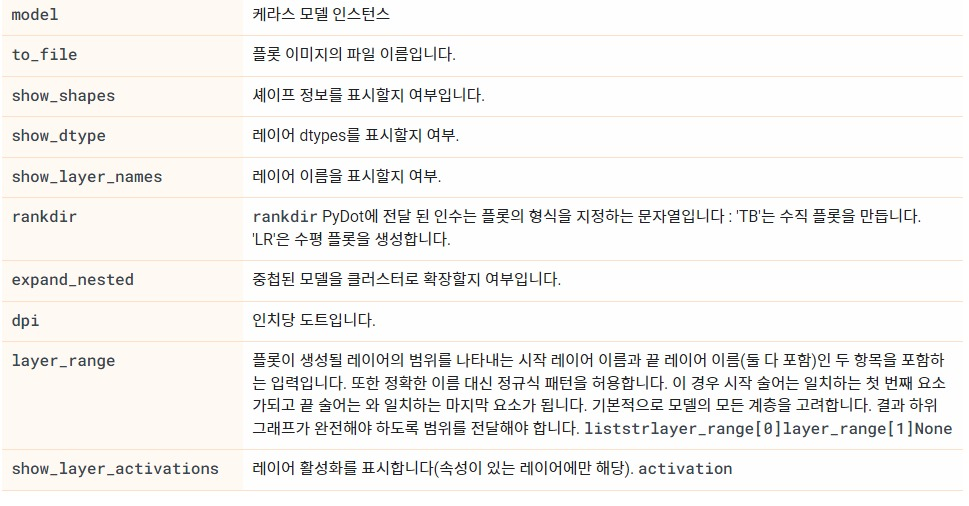

---
## 4. 모델 학습

- EarlyStopping 함수를 이용하여 val_loss가 5번의 epochs 에서 유의미한 변화를 보여주지 않으면 학습을 멈추도록 조기정지를 설정해 주었습니다.

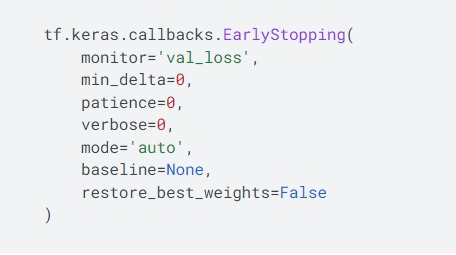

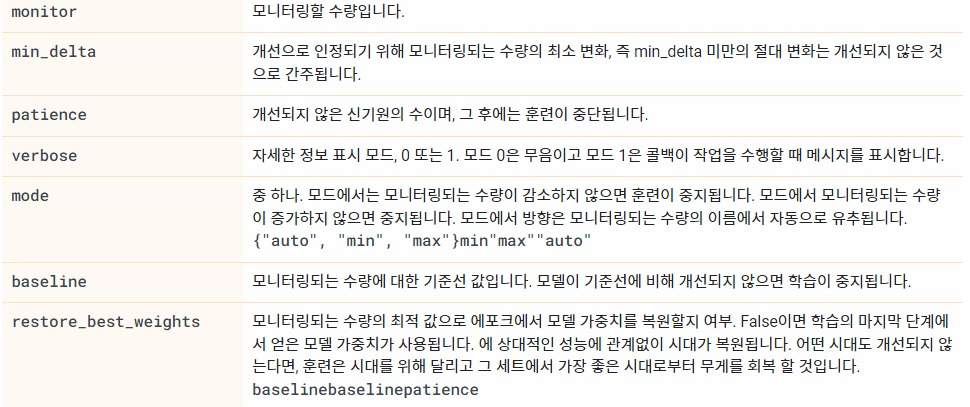

- 모델을 학습시켜보도록 하겠습니다.

In [39]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

history = model.fit(x=[eng_input_train, fra_input_train], y=fra_output_train, \
          validation_data = ([eng_input_test, fra_input_test], fra_output_test),
          batch_size=128, epochs=50, callbacks=[es])

Epoch 1/50
235/235 [==============================] - 99s 402ms/step - loss: 1.0709 - val_loss: 0.7586
Epoch 2/50
235/235 [==============================] - 95s 405ms/step - loss: 0.6839 - val_loss: 0.6499
Epoch 3/50
235/235 [==============================] - 96s 408ms/step - loss: 0.5823 - val_loss: 0.5881
Epoch 4/50
235/235 [==============================] - 95s 406ms/step - loss: 0.5049 - val_loss: 0.5504
Epoch 5/50
235/235 [==============================] - 95s 404ms/step - loss: 0.4398 - val_loss: 0.5257
Epoch 6/50
235/235 [==============================] - 95s 404ms/step - loss: 0.3820 - val_loss: 0.5128
Epoch 7/50
235/235 [==============================] - 95s 405ms/step - loss: 0.3322 - val_loss: 0.5077
Epoch 8/50
235/235 [==============================] - 95s 402ms/step - loss: 0.2898 - val_loss: 0.5117
Epoch 9/50
235/235 [==============================] - 94s 402ms/step - loss: 0.2554 - val_loss: 0.5099
Epoch 10/50
235/235 [==============================] - 95s 403ms/step - l

- 50 epochs를 설정했지만 15 epochs 만에 정지가 되었군요 loss도 유의미하게 떨어지는 모습을 확인할 수 있습니다.

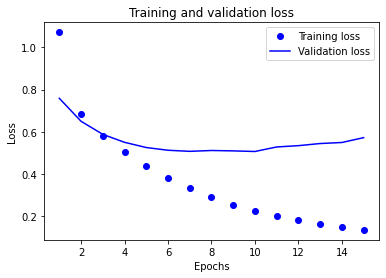

In [40]:
history_dict = history.history

# acc = history_dict['accuracy']
# val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

his_epochs = range(1, len(loss) + 1)

plt.plot(his_epochs, loss, 'bo', label='Training loss')
plt.plot(his_epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

- 음.. val_loss가 어느정도 떨어지다 다시 상승하려는 모습을 보여줍니다. overfitting이 일어난듯 합니다.
  
  
- 하지만 이를 해결하기 위해 dropout도 설정해보고 batchnormalization도 설정해 보았지만 해결되지 않았습니다..
  
  
- 그래도 성능 평가를 한번 해보도록 하겠습니다!

---
## 5. 모델 평가하기

In [41]:
encoder_model = tf.keras.Model(inputs = encoder_inputs, outputs = encoder_states)
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 256)         2152192   
_________________________________________________________________
lstm (LSTM)                  [(None, 256), (None, 256) 525312    
Total params: 2,677,504
Trainable params: 2,677,504
Non-trainable params: 0
_________________________________________________________________


In [42]:
# 이전 time step의 hidden state를 저장하는 텐서
decoder_state_input_h = tf.keras.Input(shape=(hidden_state,))
# 이전 time step의 cell state를 저장하는 텐서
decoder_state_input_c = tf.keras.Input(shape=(hidden_state,))
# 이전 time step의 hidden state와 cell state를 하나의 변수에 저장
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# decoder_states_inputs를 현재 time step의 초기 상태로 사용.
# 구체적인 동작 자체는 def decode_sequence()에 구현.
decoder_outputs, state_h, state_c = decoder_lstm(dnc_emb, initial_state = decoder_states_inputs)
# 현재 time step의 hidden state와 cell state를 하나의 변수에 저장.
decoder_states = [state_h, state_c]

In [43]:
decoder_outputs = decoder_softmax_layer(decoder_outputs)
decoder_model = tf.keras.Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs] + decoder_states)
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 256)    3705600     input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256)]        0                                            
____________________________________________________________________________________________

- 평가모델을 만들어 주었습니다. 위의 과정과 큰 차이는 없었습니다.

In [44]:
eng2idx = tokenizer_eng.word_index
fra2idx = tokenizer_fra.word_index
idx2eng = tokenizer_eng.index_word
idx2fra = tokenizer_fra.index_word

- index_to_word, word_to_index 형태로 각각 변수를 설정해주었습니다.

In [45]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # 에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1,1)) 
    target_seq[0, 0] = fra2idx[end_token]
    
    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2fra[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char

        # '<end>' 에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '<end>' or
           len(decoded_sentence) > fra_max_len):
            stop_condition = True
            
        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장     
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

- 디코딩 함수를 설정하였습니다. end_token을 만나게되면 while문을 끝내도록 설정하였습니다.
- 확인해보도록 하겠습니다.

In [62]:
for seq_index in [27444,16582,1085,8989,13622]:
    input_seq = eng_input[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', df.eng[seq_index])
    print('정답 문장:', df.fra[seq_index][7:len(df.fra[seq_index])-5]) # start_token과 end_token을 삭제하도록 설정
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-5]) # end_token을 삭제하도록 설정

-----------------------------------
입력 문장: I know I probably won't win.
정답 문장:  Je sais que je ne gagnerai probablement pas.
번역기가 번역한 문장:  je sais que je ne gagnerai pas . 
-----------------------------------
입력 문장: That's not our policy.
정답 문장:  Ce n'est pas notre politique.
번역기가 번역한 문장:  ce n'est pas notre politique . 
-----------------------------------
입력 문장: I have an urgent message from Tom.
정답 문장:  J'ai un message urgent de Tom.
번역기가 번역한 문장:  j'ai un message urgent de tom . 
-----------------------------------
입력 문장: She said that she had been happy.
정답 문장:  Elle a dit qu'elle avait été heureuse.
번역기가 번역한 문장:  elle dit qu'elle était heureuse . 
-----------------------------------
입력 문장: No one told me that she had failed.
정답 문장:  Personne ne m'a dit qu'elle avait échoué.
번역기가 번역한 문장:  personne ne m'a dit qu'elle était échoué . 


- 값으로는 임의의 값 5개를 제가 설정하였습니다.
- 해석은 아래와 같습니다.
  
---  
>- 입력 문장: I know I probably won't win.
>- 정답 문장:  Je sais que je ne gagnerai probablement pas.
>- 번역기가 번역한 문장:  je sais que je ne gagnerai pas . 
>- 실제 정답 해석 : 나는 내가 아마 이기지 못할 거란 걸 알아.
>- 번역 정답 해석 : 나는 내가 이길 수 없다는 것을 알고 있습니다.

---

>- 입력 문장: That's not our policy.
>- 정답 문장:  Ce n'est pas notre politique.
>- 번역기가 번역한 문장:  ce n'est pas notre politique . 
>- 실제 정답 해석 : 그것은 우리의 정책이 아닙니다.
>- 번역 정답 해석 : 그것은 우리의 정책이 아닙니다.

---

>- 입력 문장: I have an urgent message from Tom.
>- 정답 문장:  J'ai un message urgent de Tom.
>- 번역기가 번역한 문장:  j'ai un message urgent de tom . 
>- 실제 정답 해석 : Tom으로부터 긴급 메시지가 있습니다.
>- 번역 정답 해석 : 톰에게서 긴급 메시지가 있습니다.

---

>- 입력 문장: She said that she had been happy.
>- 정답 문장:  Elle a dit qu'elle avait été heureuse.
>- 번역기가 번역한 문장:  elle dit qu'elle était heureuse . 
>- 실제 정답 해석 : 그녀는 행복했다고 말했다.
>- 번역 정답 해석 : 그녀는 행복하다고 말합니다.

---

>- 입력 문장: No one told me that she had failed.
>- 정답 문장:  Personne ne m'a dit qu'elle avait échoué.
>- 번역기가 번역한 문장:  personne ne m'a dit qu'elle était échoué . 
>- 실제 정답 해석 : 아무도 그녀가 실패했다고 말하지 않았습니다.
>- 번역 정답 해석 : 아무도 그녀가 좌초되었다고 말하지 않았습니다.

- 대체적으로 굉장히 잘 번역하는 모습을 보여주고있습니다.
- 때때로 과거형과 현재형을 구분하지 못하는 모습도 보이고 실패 - 좌초 와 같이 비슷한 의미를 가진 단어를 보여주기도 합니다.
  
  
- 완전히 똑같은 문장들은 아무래도 overfitting을 완벽하게 해결하지 못했기에 생기는 오류라고 생각할 수 있겠습니다.
  
  
- 그래도 굉장히 좋은 성능을 보여주는군요!

---
## 6. 회고

### 이번 프로젝트를 하면서 어려웠던 점
>- 이번 프로젝트에서는 생각보다 신경망층 쌓는것이 어려웠습니다. 지금까진 Sequencial 모델만 이용해 model.add 의 방식으로 층을 쌓았는데 이번엔 functional 형식의 층을 쌓는것이 익숙하지 않아 어려웠습니다.

### 이번 프로젝트에서 학습한 내용
>- 이번 프로젝트에서는 꽤나 학습한게 많았는데 masking 방식으로 패딩을 처리하는 방법이나 각 함수들에 포함된 파라미터들과 LSTM layer에서 state_h, c 같은것을 꺼내 사용하는방법, activation 함수의 조금 더 구체적인 내용 등 재밌게 학습한 내용이 많았습니다. 

### 알아낸 점이나 모호한 점
>- 위에서 말했듯 hidden state, cell state를 LSTM layer에서 분리하여 사용하는 법을 배웠는데 이부분은 아직까지 정확하게 이해되지 않고 이를 응용하여 신경망층을 쌓는것은 아직 모호합니다. 그에 관해 공부하고 알아본 내용은 많았으나 코드적으로 적용시키기가 아직은 어렵습니다.

### 루브릭 평가지표를 맞추기 위해 노력했던 점
>- __1. 구두점, 대소문자, 띄어쓰기 등 번역기 모델에 요구되는 전처리가 정상적으로 진행되었다.__ 을 위해서는 전처리과정에서 구두점 기준으로 공백처리하고 소문자로 변형하여 띄어쓰기를 기준으로 단어 구분까지 모두 잘 처리되었습니다.
>- __2. seq2seq 모델 훈련결과를 그래프로 출력해보고, validation loss그래프가 우하향하는 경향성을 보이며 학습이 진행됨이 확인되었다.__ 이 루브릭에 관하여서는 overfitting이 일어나는것을 방지하기위해 batchnormalization과 dropout, early stopping을 사용하였지만 이를 통해 완벽하게는 해결하지 못한 모습을 보여주었습니다. 특히나 batchnormalization 은 적용해보았으나 더욱 안좋은 성능을 보여주어 dropout을 채용하여 사용하였습니다.
>- __3. 테스트용 디코더 모델이 정상적으로 만들어졌으며, input(영어)와 output(프랑스어) 모두 한글로 번역해서 결과를 출력해보았고, 둘의 내용이 유사함을 확인하였다.__ 이 루브릭에 관하여서는 상당히 유사한 결과를 보여주는 모습을 확인할 수 있습니다. 정답문장과 번역문장의 차이가 간소하였으며 서로 비슷한 의미의 단어를 사용하는 모습을 보여주고 약간의 오차라면 과거형 현재형 같은 부분은 살짝 구분하는것이 어려운게 아닌가 싶은 생각이 들었습니다.

### 루브릭 평가지표를 달성하지 못했다면 이유
>- 평가지표를 달성하지 못했다면 이유는 2번 루브릭 때문이 아닐까 싶습니다.
  
  
>- 예전부터 비롯된 문제이지만 overfitting을 완벽하게 막지 못했고 우하향하는 경향성을 보이다 뒤로 갈수록 다시 상향하는 그래프를 보여주는 모습을 보여주고 있습니다. 아직까지는 부족한 실력으로 인해 완벽하게 overfitting을 잡지 못했기 때문에 이러한 문제가 생기지 않았을까 생각해봅니다.


---
## 7. Reference

- https://wiserloner.tistory.com/1061 tf.Masking 관련 블로그
- https://www.tensorflow.org/api_docs/python/tf/keras/layers/Masking Masking 공식문서
- https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding Embedding 공식문서
- https://blog.naver.com/kwn06225/222688373277 LSTM 관련 블로그
- https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer tokenizer 공식문서
- https://codlingual.tistory.com/87 그림으로 보는 RNN/LSTM과 GRU 번역 및 정리
- https://machinelearningmastery.com/exploding-gradients-in-neural-networks/ 기울기 폭주
- https://hongl.tistory.com/236 gelu 관련 블로그
- https://peterleeeeee.github.io/categorical_cross_entropy/ crossentropy 관련 블로그


---
## 8. 자기다짐 및 아쉬운 점

- 이번 프로젝트는 상당히 흥미롭고 재밌었습니다. 요즘 차차 CV에서 NLP쪽으로 맘이 기울고 있는데 조금 더 방향성을 잡아준 프로젝트였던듯 싶습니다.
  
  
- 또한 이번 프로젝트에서 어려웠던 신경망 쌓기, state 활용하기, 다양한 activation function, losses, optimizers 사용해보기 등등 공부할 키워드를 많이 제공해준 프로젝트였다고 생각합니다.
  
  
- 앞으로도 이번 프로젝트처럼 LMS에서 제공해주는 코드들 말고도 제가 코드를 작성하여 사용해보는것이 더 좋겠다고 생각합니다.
  
  
  
- 아쉬운 점으로는 프랑스어도 재밌지만 저의 관심사중 하나가 스페인어입니다. 그래서 스페인어 번역 또한 포함시켜보고 싶었지만 이상하게 빠져들어 프랑스어에만 집중하다보니 시간분배의 실수로 스페인어 번역은 만들지 못했습니다. 다음에 혼자서 스페인어 번역을 만들어 볼 생각입니다.